In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from tqdm import tqdm
from torch import nn,optim
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.utils import save_image

In [2]:
## input_img >- hidden dim >- mean,std >- Parametrization trick >- decoder >- output_img
class VariationalAutoEndocers(nn.Module):
    def __init__(self,input_dim,h_dim = 200,z_dim = 20):
        super(VariationalAutoEndocers,self).__init__()
        # for encoder
        self.img_2hid = nn.Linear(input_dim,h_dim)
        self.hid_2mu = nn.Linear(h_dim,z_dim)
        self.hid_2sigma = nn.Linear(h_dim,z_dim)
        # for decoder
        self.z_2hid = nn.Linear(z_dim,h_dim)
        self.hid_2img = nn.Linear(h_dim,input_dim)

        self.relu = nn.ReLU()

    def encode(self,x):
        ## TODO: Define the encoder q_phi(z|x)
        h = self.relu(self.img_2hid(x))
        mu = self.hid_2mu(h)
        sigma = self.hid_2sigma(h)
        return mu,sigma

    def decode(self,z):
        ## TODO: Define the decoder p_theta(x|z)
        h = self.relu(self.z_2hid(z))
        x = torch.sigmoid(self.hid_2img(h)) ## to ensure the value of the image is between 0 and 1 because of it being a pixel value for MNIST
        return x

    def forward(self,x):
        mu,sigma = self.encode(x)
        epsilon = torch.randn_like(sigma)
        z_reparametrized = mu + sigma*epsilon ## reparametrization trick to sample from the latent space z i.e it pushes it towards the gaussian distribution and hence bring sampling into the loop of backpropagation
        x_reconstructed = self.decode(z_reparametrized)
        return x_reconstructed,mu,sigma
        

if __name__ == "__main__":
    x = torch.randn(4,784) ## batch size of 4, each have a size of 28*28
    vae = VariationalAutoEndocers(input_dim = 784)
    x_reconstructed,mu,sigma = vae(x)
    print(x_reconstructed.shape)
    print(mu.shape)
    print(sigma.shape)

torch.Size([4, 784])
torch.Size([4, 20])
torch.Size([4, 20])


In [4]:
## Configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
INPUT_DIM = 784
H_DIM = 200
Z_DIM = 20
N_EPOCHS = 100
BATCH_SIZE = 32
LEARNING_RATE = 1e-6

In [5]:
## Dataset
dataset = datasets.MNIST(root = "dataset/",train = True,transform = transforms.ToTensor(),download = True) ## the transform normalizes the data to be between 0 and 1 by dividing by 255
train_loader = DataLoader(dataset = dataset,batch_size = BATCH_SIZE,shuffle = True)
model = VariationalAutoEndocers(input_dim = INPUT_DIM,h_dim = H_DIM,z_dim = Z_DIM).to(DEVICE)
optimizer = optim.Adam(model.parameters(),lr = LEARNING_RATE)
loss_fnc = nn.BCELoss(reduction = "sum") ## reduction = "sum" because we want to sum the loss over all the pixels in the image, this loss works not only for binary values nut also for float values


In [6]:
## Training
for epoch in range(N_EPOCHS):
    loop = tqdm(enumerate(train_loader)) ## tqdm is a progress bar , its comes with a enumerate function which gives the index of the batch and the batch itself, also tqdm comes from the arabic word "taqaddum" which means progress
    for batch_idx,(x,_) in loop:
        x = x.to(DEVICE)
        x = x.view(x.shape[0],INPUT_DIM) ## flattening the image ## data.shape[0] is the batch size ## data.shape[1] is the number of channels ## data.shape[2] is the height of the image ## data.shape[3] is the width of the image ## In this case view will do the same thing as reshape but it is more efficient as it does not copy the data
        x_reconstructed,mu,sigma = model(x)

        ## Reconstruction loss
        reconstruction_loss = loss_fnc(x_reconstructed,x) ## already a minus sign in the loss for minimization
        kl_d = 0.5*torch.sum(mu**2 + sigma**2 - torch.log(sigma**2) - 1) ## KL divergence
        #kl_divergence = -(torch.sum(1 + torch.log(sigma.pow(2)) - mu.pow(2) - sigma.pow(2))/2) ## it will push it towards the standard guassian

        ## Backpropagation
        loss = reconstruction_loss + kl_d
        optimizer.zero_grad() ## No accumulated gradient from before
        loss.backward()
        optimizer.step()
        loop.set_postfix(loss = loss.item()) ##set_postfix is a function of tqdm which will show the loss in the progress bar
    


1875it [00:06, 276.31it/s, loss=1.88e+4]
1875it [00:06, 278.27it/s, loss=1.85e+4]
1875it [00:06, 279.56it/s, loss=1.8e+4] 
1875it [00:06, 277.24it/s, loss=1.75e+4]
1875it [00:06, 277.88it/s, loss=1.7e+4] 
1875it [00:06, 280.85it/s, loss=1.62e+4]
1875it [00:06, 278.91it/s, loss=1.56e+4]
1875it [00:06, 275.56it/s, loss=1.45e+4]
1875it [00:06, 276.31it/s, loss=1.36e+4]
1875it [00:06, 277.60it/s, loss=1.31e+4]
1875it [00:06, 274.94it/s, loss=1.19e+4]
1875it [00:06, 276.68it/s, loss=1.12e+4]
1875it [00:06, 276.66it/s, loss=1.05e+4]
1875it [00:06, 276.09it/s, loss=1e+4]   
1875it [00:06, 272.92it/s, loss=9.61e+3]
1875it [00:06, 273.65it/s, loss=9.02e+3]
1875it [00:06, 272.58it/s, loss=9.32e+3]
1875it [00:06, 273.47it/s, loss=8.86e+3]
1875it [00:06, 273.57it/s, loss=8.38e+3]
1875it [00:06, 270.03it/s, loss=8.32e+3]
1875it [01:17, 24.34it/s, loss=8e+3]    
1875it [04:37,  6.76it/s, loss=8.96e+3] 
1875it [00:07, 261.40it/s, loss=8.3e+3] 
1875it [00:07, 255.24it/s, loss=8.56e+3]
1875it [00:06, 2

In [7]:
## Inferencing
def inference(digit, num_examples):
    """
    Generates (num_examples) of a particular digit.
    Specifically we extract an example of each digit,
    then after we have the mu, sigma representation for
    each digit we can sample from that.

    After we sample we can run the decoder part of the VAE
    and generate examples.
    """
    images = []
    idx = 0
    for x, y in dataset:
        if y == idx:
            images.append(x)
            idx += 1
        if idx == 10:
            break

    encodings_digit = []
    for d in range(10):
        with torch.no_grad():
            mu, sigma = model.encode(images[d].view(1, 784))
        encodings_digit.append((mu, sigma))

    mu, sigma = encodings_digit[digit]
    for example in range(num_examples):
        epsilon = torch.randn_like(sigma)
        z = mu + sigma * epsilon
        out = model.decode(z)
        out = out.view(-1, 1, 28, 28)
        save_image(out, f"generated_{digit}_ex{example}.png")

    

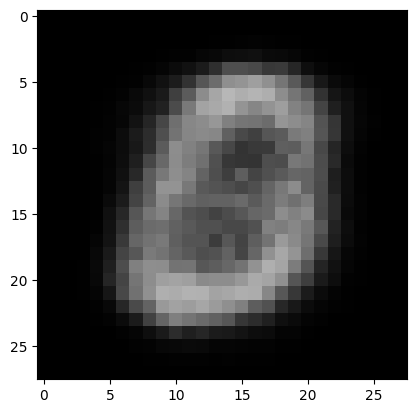

In [11]:
## Inference
inference(0, 10)

## print the image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('generated_0_ex0.png')
imgplot = plt.imshow(img)
plt.show()


